之前的章节介绍了基于策略梯度的算法 REINFORCE、Actor-Critic 以及两个改进算法——TRPO 和 PPO。这类算法有一个共同的特点：它们都是在线策略算法，这意味着它们的样本效率（sample efficiency）比较低。我们回忆一下 DQN 算法，DQN 算法直接估计最优函数 $Q^*$ ，可以做到离线策略学习，但是它只能处理动作空间有限的环境，这是因为它需要从所有动作中挑选一个 $Q$ 值最大的动作。如果动作个数是无限的，虽然我们可以像 8.3 节一样，将动作空间离散化，但这比较粗糙，无法精细控制。那有没有办法可以用类似的思想来处理动作空间无限的环境并且使用的是离线策略算法呢？本章要讲解的深度确定性策略梯度（Deep Deterministic Policy Gradient，DDPG）算法就是如此，它构造一个确定性策略，用梯度上升的方法来最大化 $Q$ 值。DDPG 也属于一种 Actor-Critic 算法。我们之前学习的 REINFORCE、TRPO 和 PPO 学习随机性策略，而本章的 DDPG 则学习一个确定性策略

确定性策略梯度定理：

$$\nabla_\theta J(\pi_\theta)=\mathbb{E}_{s\sim\nu^{\pi_\beta}}\left[\nabla_\theta\mu_\theta(s)\nabla_aQ_\omega^\mu(s,a)|_{a=\mu_\theta(s)}\right]$$

其中 $ \nu_\theta (s) $ 为确定性策略，$\pi_\beta $ 是用来收集数据的行为策略。我们可以这样理解这个定理：假设现在已经有函数$Q$,给定一个状态$s$,但由于现在动作空间是无限的，无法通过遍历所有动作来得到$Q$值最大的动作，因此我们想用策略$\mu$找到使$Q(s,a)$值最大的动作$a$,即$\mu(s)=\arg\max_aQ(s,a)$。此时，$Q$就是 Critic,$\mu$就是 Actor,这是一个 Actor-Critic 的框架，如图所示。

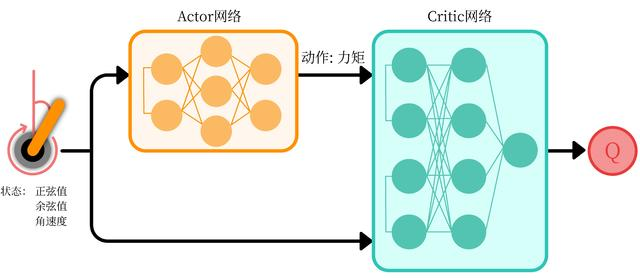

一共要用四个网络，分别是 $\nu$ 和 $Q$ 的网络，以及它们的目标网络。

DDPG 中 Actor 也需要目标网络, 因为目标网络也会被用来计算目标 $Q$ 值。DDPG 中目标网络的更新与 DQN 中略有不同：在 DQN 中，每隔一段时间将$Q$网络直接复制给目标 $Q$ 网络；而在DDPG 中，目标$Q$网络的更新采取的是一种软更新的方式，即让目标 $Q$ 网络缓慢更新，逐渐接近$Q$网络，其公式为：

$$\omega^-\leftarrow\tau\omega+(1-\tau)\omega^-$$

通常$\tau$是一个比较小的数，当$\tau=1$时，就和 DQN 的更新方式一致了。而目标$\mu$网络也使用这种软更新的方式。

另外，由于函数 $Q$ 存在 $Q$ 值过高估计的问题，DDPG 采用了 Double DQN 中的技术来更新$Q$网络。但是，由于 DDPG 采用的是确定性策略，它本身的探索仍然十分有限。回忆一下DQN算法，它的探索主要由 $\epsilon$ -贪婪策略的行为策略产生。同样作为一种离线策略的算法，DDPG 在行为策略上引入一个随机噪声 $N$ 来进行探索。来看一下DDPG的具体算法流程:

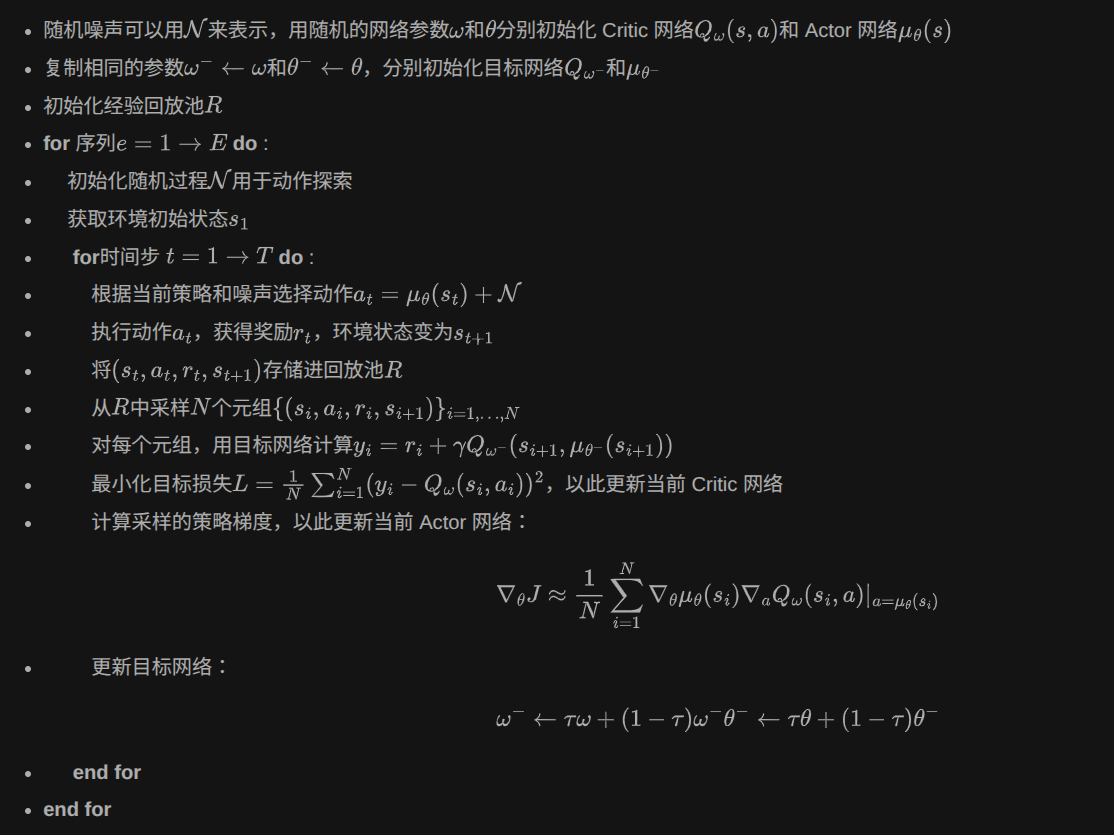

In [3]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) # 沿特征维度拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 更新Actor和Critic网络
        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

Iteration 9: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s, episode=200, return=-153.922]


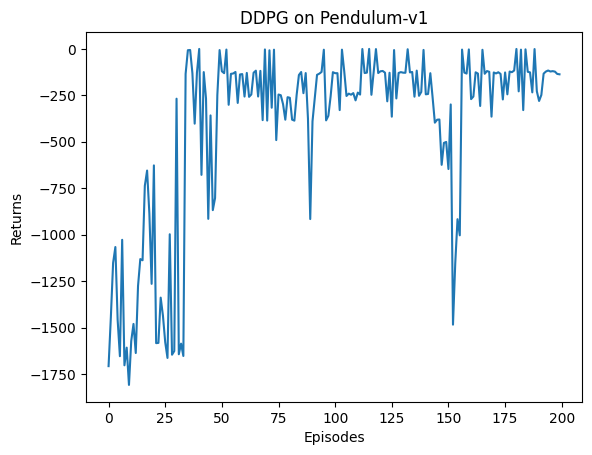

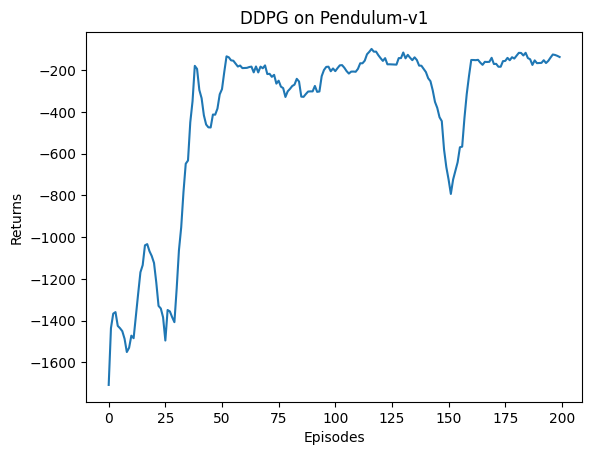

In [4]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()